# Reading Prism and Storm models using Stormpy

For parsing and building [PRISM] models, we rely on [Stormpy] and [Storm]. In this notebook, we demonstrate how the interface works.

Let's first create some model in the [PRISM language]. We create a simple grid-world model where the agent can move into 4 directions (`NORTH`, `SOUTH`, `EAST`, and `WEST`) and he has 2 types of actions for each direction. The strong actions cost 3 units of energy and lead to the requested direction deterministically. The weak actions are cheaper, they cost only 1 unit of energy, but inctorduce a stochastic failure and can drift the agent into one of the two diagonal directions (for `NORTH` this would be north-west or north-east) with a small probability.

The encoding of Consumption MDPs is done as a standard `mdp` model with two additional requirements.

 1. The consumption of actions is given by a reward structure called `consumption`. This reward structure has to assign some consumption to each action (choice).
 2. The set of reload states must be specified using the `reload` state label.
 
Note that such encoding **does not** produce model with the same semantics in PRISM and other tools.

Further, we allow to define the targets using the `target` label and capacity using the `capacity` constant in the prism model. These are defined at the bottom of the following file.

[Storm]: https://www.stormchecker.org/
[Stormpy]: https://moves-rwth.github.io/stormpy/index.html
[PRISM]: https://www.prismmodelchecker.org/
[PRISM language]: https://www.prismmodelchecker.org/manual/ThePRISMLanguage/Introduction

In [1]:
%%writefile gw.prism
mdp

const int size_x = 10;
const int size_y = 10;
const int border_x = size_x-1;
const int border_y = size_y-1;

// Let's set some reload states
formula is_reload = (x=round(border_x/2) & y=round(border_y/2));

// Consumption of strong and weak actions
const int cons_s = 3;
const int cons_w = 1;

const double succ_p = 0.9;
const double fail_left_p = 0.04;
const double fail_right_p = 0.06;

// Conditions for hitting walls — robot
formula wall_north = (y = border_y);
formula wall_east = (x = border_x); 
formula wall_south = (y = 0);
formula wall_west = (x = 0);

module movement
  x : [0..size_x-1] init 0;
  y : [0..size_y-1] init 0;

  [strong_north] !wall_north -> (y'=y+1);
  [north] !wall_north & !wall_east & !wall_west -> 
	succ_p: (y'=y+1) + 
	fail_left_p: (y'=y+1)&(x'=x-1) + 
	fail_right_p: (y'=y+1)&(x'=x+1);
  [north] !wall_north &  wall_east & !wall_west -> 
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x-1); 
  [north] !wall_north & !wall_east &  wall_west -> 
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x+1);

  [strong_south] !wall_south -> (y'=y-1);
  [south] !wall_south & !wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	fail_left_p: (y'=y-1)&(x'=x-1) + 
	fail_right_p: (y'=y-1)&(x'=x+1);
  [south] !wall_south &  wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x-1); 
  [south] !wall_south & !wall_east &  wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x+1); 

  [strong_east] !wall_east -> (x'=x+1);
  [east] !wall_east & !wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	fail_left_p: (x'=x+1)&(y'=y-1) + 
	fail_right_p: (x'=x+1)&(y'=y+1);
  [east] !wall_east &  wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y-1); 
  [east] !wall_east & !wall_north &  wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y+1); 

  [strong_west] !wall_west -> (x'=x-1);
  [west] !wall_west & !wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	fail_left_p: (x'=x-1)&(y'=y-1) + 
	fail_right_p: (x'=x-1)&(y'=y+1);
  [west] !wall_west &  wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y-1); 
  [west] !wall_west & !wall_north &  wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y+1); 

endmodule

rewards "consumption"
	[north] true : cons_w;
	[south] true : cons_w;
	[east] true : cons_w;
	[west] true : cons_w;
	[strong_north] true : cons_s;
	[strong_south] true : cons_s;
	[strong_east] true : cons_s;
	[strong_west] true : cons_s;
endrewards

label "reload" = is_reload;
label "target" = (x=border_x & y=2);
const int capacity = 2 * size_x;

Overwriting gw.prism


We can get a consumption MDP right from the model using the `prism_to_consmdp` function.

In [2]:
import fimdp
fimdp.setup()
from fimdp.io import prism_to_consmdp
mdp = prism_to_consmdp("gw.prism")
print(mdp.num_states)

100


By default, this functions keeps the action names and stores the variable valuations in state names.

In [3]:
print(mdp.names[15])
print(mdp.actions[mdp.succ[15]])
print(mdp.names[13])

15: x=3 y=0
15——strong_north[3]——>{13: 1.0}
13: x=3 y=1


Names of states can be discarded by setting `state_valuations=False` and action labels can be discarded by `action_labels=False`

In [4]:
pure_mdp = prism_to_consmdp("gw.prism", 
                            state_valuations=False,
                            action_labels=False)
print(pure_mdp.names[15])
print(pure_mdp.actions[mdp.succ[15]])
print(pure_mdp.names[13])

None
15——106[3]——>{13: 1.0}
None


### Targets and capacity

In our example, we have defined the targets and capacity we want to use in our analysis. We can read the targets by passing `return_targets=True` to the `prism_to_consmdp` function, and we can read the capacity using the function `parse_cap_from_prism`.

In [5]:
from fimdp.io import parse_cap_from_prism
from fimdp.energy_solvers import BasicES
from fimdp.objectives import BUCHI

mdp, targets = prism_to_consmdp("gw.prism", return_targets=True)
capacity = parse_cap_from_prism("gw.prism")
print(targets)
print(capacity)
solver = BasicES(mdp, capacity, targets)
print(solver.get_min_levels(BUCHI))

[98]
20
[20, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 15, 12, 17, 15, 17, 16, 15, 12, 9, 6, 12, 9, 16, 15, 15, 12, 9, 6, 3, 0, 6, 3, 12, 9, 15, 16, 15, 12, 9, 6, 3, 6, 6, 3, 12, 9, 16, 15, 17, 16, 15, 12, 9, 6, 9, 12, 6, 9, 12, 9, 16, 15, 17, 17, 16, 15, 14, 12, 9, 12, 14, 15, 12, 14, 12, 9, 15, 14, 17, 16, 17, 16, 15, 14, 13, 12, 13, 14, 15, 16, 14, 15, 12, 13, 14, 13, 16, 15, 17]


## Stormpy models

FiMDP also offers `storm_sparsemdp_to_consmdp` which translates a stormpy sparse representation of MDP (satisfying the same requirements as for PRISM) into Consumption MDP. It also offers `consmdp_to_storm_consmdp` which encodes the FiMDP representation into SparseMDP from Storm. This encoding is exactly such that it can be used to build the ConsMDP object back.

In [6]:
from fimdp.io import consmdp_to_storm_consmdp, storm_sparsemdp_to_consmdp
from fimdp.examples.cons_mdp import little_alsure
from fimdp.dot import dot_to_svg
from IPython.display import SVG
import stormpy

def display_storm(sparseMDP):
    return SVG(dot_to_svg(sparseMDP.to_dot()))

In [7]:
m, T = little_alsure()
storm = consmdp_to_storm_consmdp(m)

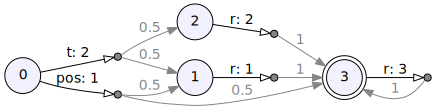

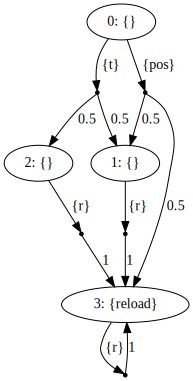

In [8]:
display(m, display_storm(storm))

We can also encode the target states.

{1, 2}


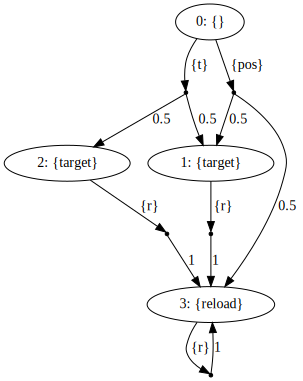

In [9]:
print(T)
display_storm(consmdp_to_storm_consmdp(m, T))

Let's see if the conversion back works as expected.

In [10]:
m.get_dot() == storm_sparsemdp_to_consmdp(storm).get_dot()

False

Analogously to the PRISM models, we can also read the target states back from the Storm's representation of ConsMDPs.

In [11]:
st_targets = consmdp_to_storm_consmdp(m, T)
mdp, st_T = storm_sparsemdp_to_consmdp(st_targets, return_targets=True)
set(st_T) == T

True

## Encoding energy into state-space using FiMDP
If we want to analyze consumption MDPs in Storm, we need to encode the energy explicitly into the state-space. This means, for different capacity values we have different MDPs. We can achieve that with the function `fimdp.explicit.product_energy` and then with the `consmdp_to_storm_consmdp` function discussed above. Let's illustrate that on the grid-world example. The explicit encoding increases, of course, the number of states.

In [12]:
from fimdp.explicit import product_energy

In [13]:
mdp, targets = prism_to_consmdp("gw.prism", return_targets=True)
capacity = parse_cap_from_prism("gw.prism")
product, product_targets = product_energy(mdp, capacity, targets)
storm_mdp = consmdp_to_storm_consmdp(product, product_targets)

In [14]:
print(f"The number of states in the consumption MDP: {mdp.num_states}")
print(f"The number of states in the explicit MDP: {product.num_states}")
print(f"The number of states in the explicit MDP in Storm: {storm_mdp.nr_states}")

The number of states in the consumption MDP: 100
The number of states in the explicit MDP: 2081
The number of states in the explicit MDP in Storm: 2081


This workflow is implemented in function `fimdp.io.encode_to_stormpy` which takes the original ConsMDP, capacity, and targets and returns the storm explicit encoding of the Consumption MDP

In [15]:
from fimdp.io import encode_to_stormpy
storm_mdp = encode_to_stormpy(mdp, capacity, targets)
print(f"The number of states in the explicit MDP in Storm: {storm_mdp.nr_states}")

The number of states in the explicit MDP in Storm: 2081


We are now ready to analyze the product using stormpy. Let's check the almost-sure reachability (and survival) which can be expressed by the following [PCTL] formula. Intuitivelly, we ask if we can achieve the probability 1 of eventually (`F`) visiting a state labeled with the label `"target"` and such that we can, with probability 1 survive from that state. The survival is encoded by visiting _reload_ states infinitely often (always eventually = `GF`).

[PCTL]: https://www.stormchecker.org/documentation/background/properties.html

In [16]:
formula = 'Pmax>=1 [F "target" & Pmax>=1 [F "reload"]]'
prop = stormpy.parse_properties(formula)

In [17]:
storm_result = stormpy.model_checking(storm_mdp, prop[0])

Let's now check if the results agree with the ones achieved by FiMDP. We do that by checking whether Storm claims the validity of the formula exactly for the states of the product with the form `(s,e)`, where `e` is the energy and is at least equal to the value returned by the FiMDP solver for `s`.

In [18]:
from fimdp.objectives import AS_REACH
from fimdp.energy_solvers import BasicES
solver = BasicES(mdp, capacity, targets)

fimdp_res = solver.get_min_levels(AS_REACH)

for s in range(product.num_states):
    state, energy = product.components[s]
    if energy == "-∞":
        assert not storm_result.at(s)
        continue
    assert storm_result.at(s) == (int(energy) >= solver.get_min_levels(AS_REACH)[state])

## Encoding energy into state-space in the PRISM model
The encoding can be added simply to our model through the synchronization of modules in PRISM models. To be more concrete, we add a new module, called `energy` into our model. In this module, we model how energy is treated in consumption MDPs. An action decreases the energy level and it can only be taken if the energy level would not drop below 0 after the action. Also, the energy is replenished in reload states.

For our example, the `energy` module can look like this. The actions of the `energy` module synchronize with the actions of the `movement` module with the same label. The effect on energy depends on whether or not we are in a reload state.

The full model is defined below. Of course, we do not longer need the `consumption` reward.

In [19]:
%%writefile gw_explicit.prism
mdp

const int size_x = 10;
const int size_y = 10;

const int capacity = 18;

const int cons_w = 1;
const int cons_s = 3;

const int border_x = size_x-1;
const int border_y = size_y-1;

formula is_reload = (x=round(border_x/2) & y=round(border_y/2)) |
                    (x=5 & y=5) |
                    (x=round(border_x/3) & mod(y,15)=7);

const double succ_p = 0.9;
const double fail_left_p = 0.04;
const double fail_right_p = 0.06;


// Conditions for hitting walls — robot
formula wall_north = (y = border_y);
formula wall_east = (x = border_x); 
formula wall_south = (y = 0);
formula wall_west = (x = 0);

// Conditions for weak and strong actions
formula allowed_w = (e-cons_w >=0);
formula allowed_s = (e-cons_s >=0);
formula allowed_w_r = (capacity-cons_w >=0);
formula allowed_s_r = (capacity-cons_s >=0);

module movement
  x : [0..size_x-1] init 0;
  y : [0..size_y-1] init 0;

  [strong_north] !wall_north -> (y'=y+1);
  [north] !wall_north & !wall_east & !wall_west ->
	succ_p: (y'=y+1) + 
	fail_left_p: (y'=y+1)&(x'=x-1) + 
	fail_right_p: (y'=y+1)&(x'=x+1);
  [north] !wall_north &  wall_east & !wall_west ->
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x-1); 
  [north] !wall_north & !wall_east &  wall_west ->
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x+1);

  [strong_south] !wall_south -> (y'=y-1);
  [south] !wall_south & !wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	fail_left_p: (y'=y-1)&(x'=x-1) + 
	fail_right_p: (y'=y-1)&(x'=x+1);
  [south] !wall_south &  wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x-1); 
  [south] !wall_south & !wall_east &  wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x+1); 

  [strong_east] !wall_east -> (x'=x+1);
  [east] !wall_east & !wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	fail_left_p: (x'=x+1)&(y'=y-1) + 
	fail_right_p: (x'=x+1)&(y'=y+1);
  [east] !wall_east &  wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y-1); 
  [east] !wall_east & !wall_north &  wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y+1); 

  [strong_west] !wall_west -> (x'=x-1);
  [west] !wall_west & !wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	fail_left_p: (x'=x-1)&(y'=y-1) + 
	fail_right_p: (x'=x-1)&(y'=y+1);
  [west] !wall_west &  wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y-1); 
  [west] !wall_west & !wall_north &  wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y+1); 

endmodule

module energy
  e : [0..capacity] init capacity;

  // NO RELOADS
  [strong_north] !is_reload & allowed_s -> (e'=e-cons_s);
  [strong_south] !is_reload & allowed_s -> (e'=e-cons_s);
  [strong_east] !is_reload & allowed_s -> (e'=e-cons_s);
  [strong_west] !is_reload & allowed_s -> (e'=e-cons_s);
  [north] !is_reload & allowed_w -> (e'=e-cons_w);
  [south] !is_reload & allowed_w -> (e'=e-cons_w);
  [east] !is_reload & allowed_w -> (e'=e-cons_w);
  [west] !is_reload & allowed_w -> (e'=e-cons_w);

  //RELOADS
  [strong_north] is_reload & allowed_s_r -> (e'=capacity-cons_s);
  [strong_south] is_reload & allowed_s_r -> (e'=capacity-cons_s);
  [strong_east] is_reload & allowed_s_r -> (e'=capacity-cons_s);
  [strong_west] is_reload & allowed_s_r -> (e'=capacity-cons_s);
  [north] is_reload & allowed_w_r -> (e'=capacity-cons_w);
  [south] is_reload & allowed_w_r -> (e'=capacity-cons_w);
  [east] is_reload & allowed_w_r -> (e'=capacity-cons_w);
  [west] is_reload & allowed_w_r -> (e'=capacity-cons_w);
endmodule

label "reload" = is_reload;
label "target" = (x=border_x-2) & (y=border_y);

Overwriting gw_explicit.prism


This encoding yields a slightly smaller model than the one produced by FiMDP. The reason is that FiMDP does not use initial states, rather it builds the product from all states. This might change in the future.

In [20]:
file_ex = "gw_explicit.prism"
prism_ex = stormpy.parse_prism_program("gw_explicit.prism")
storm_ex = stormpy.build_model(prism_ex)
storm_ex.nr_states

1642

## Hybrid encoding in PRISM
Now we want to describe one PRISM model, that can be used by both FiMDP and by Storm without the product built by FiMDP. The key concept here are uninitialized constants that we used to define the consumption for the explicit encoding (the `energy` module).
```
const int cons_w = 1;
const int cons_s = 3;
// Consumption for the explicit encoding of energy
const int cons_w_ex;
const int cons_s_ex;
```

We then have 2 possibilities how to set `cons_w_ex` and `cons_s_ex`:
 1. both to `0`: only the grid is built and consMDP can be easily created
 2. to `cons_w` and `cons_s`: the product is built and can be used directly by Stormpy

In [21]:
%%writefile gw_hybrid.prism
mdp

const int size_x = 10;
const int size_y = 10;

const int capacity = 18;

const int cons_w = 1;
const int cons_s = 3;
// Consumption for the explicit encoding is left intentionally
// uninitialized. When set to 0, just the grid is built,
// if set to cons_w and cons_s, the product is built.
const int cons_w_ex;
const int cons_s_ex;

const int border_x = size_x-1;
const int border_y = size_y-1;

formula is_reload = (x=round(border_x/2) & y=round(border_y/2)) |
                    (x=5 & y=5) |
                    (x=round(border_x/3) & mod(y,15)=7);

const double succ_p = 0.9;
const double fail_left_p = 0.04;
const double fail_right_p = 0.06;


// Conditions for hitting walls — robot
formula wall_north = (y = border_y);
formula wall_east = (x = border_x); 
formula wall_south = (y = 0);
formula wall_west = (x = 0);

// Conditions for weak and strong actions
formula allowed_w = (e-cons_w_ex >=0);
formula allowed_s = (e-cons_s_ex >=0);
formula allowed_w_r = (capacity-cons_w_ex >=0);
formula allowed_s_r = (capacity-cons_s_ex >=0);

module movement
  x : [0..size_x-1] init 0;
  y : [0..size_y-1] init 0;

  [strong_north] !wall_north -> (y'=y+1);
  [north] !wall_north & !wall_east & !wall_west ->
	succ_p: (y'=y+1) + 
	fail_left_p: (y'=y+1)&(x'=x-1) + 
	fail_right_p: (y'=y+1)&(x'=x+1);
  [north] !wall_north &  wall_east & !wall_west ->
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x-1); 
  [north] !wall_north & !wall_east &  wall_west ->
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x+1);

  [strong_south] !wall_south -> (y'=y-1);
  [south] !wall_south & !wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	fail_left_p: (y'=y-1)&(x'=x-1) + 
	fail_right_p: (y'=y-1)&(x'=x+1);
  [south] !wall_south &  wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x-1); 
  [south] !wall_south & !wall_east &  wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x+1); 

  [strong_east] !wall_east -> (x'=x+1);
  [east] !wall_east & !wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	fail_left_p: (x'=x+1)&(y'=y-1) + 
	fail_right_p: (x'=x+1)&(y'=y+1);
  [east] !wall_east &  wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y-1); 
  [east] !wall_east & !wall_north &  wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y+1); 

  [strong_west] !wall_west -> (x'=x-1);
  [west] !wall_west & !wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	fail_left_p: (x'=x-1)&(y'=y-1) + 
	fail_right_p: (x'=x-1)&(y'=y+1);
  [west] !wall_west &  wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y-1); 
  [west] !wall_west & !wall_north &  wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y+1); 

endmodule

module energy
  e : [0..capacity] init capacity;

  // NO RELOADS
  [strong_north] !is_reload & allowed_s -> (e'=e-cons_s_ex);
  [strong_south] !is_reload & allowed_s -> (e'=e-cons_s_ex);
  [strong_east] !is_reload & allowed_s -> (e'=e-cons_s_ex);
  [strong_west] !is_reload & allowed_s -> (e'=e-cons_s_ex);
  [north] !is_reload & allowed_w -> (e'=e-cons_w_ex);
  [south] !is_reload & allowed_w -> (e'=e-cons_w_ex);
  [east] !is_reload & allowed_w -> (e'=e-cons_w_ex);
  [west] !is_reload & allowed_w -> (e'=e-cons_w_ex);

  //RELOADS
  [strong_north] is_reload & allowed_s_r -> (e'=capacity-cons_s_ex);
  [strong_south] is_reload & allowed_s_r -> (e'=capacity-cons_s_ex);
  [strong_east] is_reload & allowed_s_r -> (e'=capacity-cons_s_ex);
  [strong_west] is_reload & allowed_s_r -> (e'=capacity-cons_s_ex);
  [north] is_reload & allowed_w_r -> (e'=capacity-cons_w_ex);
  [south] is_reload & allowed_w_r -> (e'=capacity-cons_w_ex);
  [east] is_reload & allowed_w_r -> (e'=capacity-cons_w_ex);
  [west] is_reload & allowed_w_r -> (e'=capacity-cons_w_ex);
endmodule

rewards "consumption"
	[north] true : cons_w;
	[south] true : cons_w;
	[east] true : cons_w;
	[west] true : cons_w;
	[strong_north] true : cons_s;
	[strong_south] true : cons_s;
	[strong_east] true : cons_s;
	[strong_west] true : cons_s;
endrewards

label "reload" = is_reload;
label "target" = (x=border_x-2) & (y=border_y);

Overwriting gw_hybrid.prism


In [22]:
file_hybrid = "gw_hybrid.prism"
prism_hybrid = stormpy.parse_prism_program(file_hybrid)

The `prism_hybrid` program contains the uninitialized constants. In the following cells, we create two concrete prism programs by instantiating the variables as described above.|

In [23]:
man = prism_hybrid.expression_manager
cons_w = man.get_variable("cons_w_ex")
cons_s = man.get_variable("cons_s_ex")
zero = man.create_integer(0)
cons_w_ex = man.get_variable("cons_w").get_expression()
cons_s_ex = man.get_variable("cons_s").get_expression()

prism_consmdp = prism_hybrid.define_constants({cons_w : zero, cons_s : zero})
storm_consmdp = stormpy.build_model(prism_consmdp)
prism_storm = prism_hybrid.define_constants({cons_w : cons_w_ex, cons_s : cons_s_ex})
storm_hybrid = stormpy.build_model(prism_storm)

In [24]:
fimdp_hybrid = storm_sparsemdp_to_consmdp(storm_consmdp)
fimdp_hybrid.num_states

100

In [25]:
storm_hybrid.nr_states

1642

### Parametric models

With the uninitialized constants, one can even build parametric models (e.g. for the size of the grid) in the very same fashion. So let's keep the size and capacity undefined and define them later.

In [26]:
%%writefile gw_param.prism
mdp

const int size_x;
const int size_y;

const int capacity;

const int cons_w = 1;
const int cons_s = 3;
// Consumption for the explicit encoding is left intentionally
// uninitialized. When set to 0, just the grid is built,
// if set to cons_w and cons_s, the product is built.
const int cons_w_ex;
const int cons_s_ex;

const int border_x = size_x-1;
const int border_y = size_y-1;

formula is_reload = (x=round(border_x/2) & y=round(border_y/2)) |
                    (x=5 & y=5) |
                    (x=round(border_x/3) & mod(y,15)=7);

const double succ_p = 0.9;
const double fail_left_p = 0.04;
const double fail_right_p = 0.06;


// Conditions for hitting walls — robot
formula wall_north = (y = border_y);
formula wall_east = (x = border_x); 
formula wall_south = (y = 0);
formula wall_west = (x = 0);

// Conditions for weak and strong actions
formula allowed_w = (e-cons_w_ex >=0);
formula allowed_s = (e-cons_s_ex >=0);
formula allowed_w_r = (capacity-cons_w_ex >=0);
formula allowed_s_r = (capacity-cons_s_ex >=0);

module movement
  x : [0..size_x-1] init 0;
  y : [0..size_y-1] init 0;

  [strong_north] !wall_north -> (y'=y+1);
  [north] !wall_north & !wall_east & !wall_west ->
	succ_p: (y'=y+1) + 
	fail_left_p: (y'=y+1)&(x'=x-1) + 
	fail_right_p: (y'=y+1)&(x'=x+1);
  [north] !wall_north &  wall_east & !wall_west ->
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x-1); 
  [north] !wall_north & !wall_east &  wall_west ->
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x+1);

  [strong_south] !wall_south -> (y'=y-1);
  [south] !wall_south & !wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	fail_left_p: (y'=y-1)&(x'=x-1) + 
	fail_right_p: (y'=y-1)&(x'=x+1);
  [south] !wall_south &  wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x-1); 
  [south] !wall_south & !wall_east &  wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x+1); 

  [strong_east] !wall_east -> (x'=x+1);
  [east] !wall_east & !wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	fail_left_p: (x'=x+1)&(y'=y-1) + 
	fail_right_p: (x'=x+1)&(y'=y+1);
  [east] !wall_east &  wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y-1); 
  [east] !wall_east & !wall_north &  wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y+1); 

  [strong_west] !wall_west -> (x'=x-1);
  [west] !wall_west & !wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	fail_left_p: (x'=x-1)&(y'=y-1) + 
	fail_right_p: (x'=x-1)&(y'=y+1);
  [west] !wall_west &  wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y-1); 
  [west] !wall_west & !wall_north &  wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y+1); 

endmodule

module energy
  e : [0..capacity] init capacity;

  // NO RELOADS
  [strong_north] !is_reload & allowed_s -> (e'=e-cons_s_ex);
  [strong_south] !is_reload & allowed_s -> (e'=e-cons_s_ex);
  [strong_east] !is_reload & allowed_s -> (e'=e-cons_s_ex);
  [strong_west] !is_reload & allowed_s -> (e'=e-cons_s_ex);
  [north] !is_reload & allowed_w -> (e'=e-cons_w_ex);
  [south] !is_reload & allowed_w -> (e'=e-cons_w_ex);
  [east] !is_reload & allowed_w -> (e'=e-cons_w_ex);
  [west] !is_reload & allowed_w -> (e'=e-cons_w_ex);

  //RELOADS
  [strong_north] is_reload & allowed_s_r -> (e'=capacity-cons_s_ex);
  [strong_south] is_reload & allowed_s_r -> (e'=capacity-cons_s_ex);
  [strong_east] is_reload & allowed_s_r -> (e'=capacity-cons_s_ex);
  [strong_west] is_reload & allowed_s_r -> (e'=capacity-cons_s_ex);
  [north] is_reload & allowed_w_r -> (e'=capacity-cons_w_ex);
  [south] is_reload & allowed_w_r -> (e'=capacity-cons_w_ex);
  [east] is_reload & allowed_w_r -> (e'=capacity-cons_w_ex);
  [west] is_reload & allowed_w_r -> (e'=capacity-cons_w_ex);
endmodule

rewards "consumption"
	[north] true : cons_w;
	[south] true : cons_w;
	[east] true : cons_w;
	[west] true : cons_w;
	[strong_north] true : cons_s;
	[strong_south] true : cons_s;
	[strong_east] true : cons_s;
	[strong_west] true : cons_s;
endrewards
                                     
label "reload" = is_reload;
label "target" = (x=border_x-2) & (y=border_y);

Overwriting gw_param.prism


To set the concrete values for the constants, we can pass a dictionary of the intended values to `prism_to_consmdp` function. This will take them, converts to stormpy internals, and builds the program with them. The type of the values must be:
 1. an integer, or
 2. a string that matches one of the other constants
 
Let's first recreate the two models we've already seen.

In [27]:
constants = {
    "size_x" : 10,
    "size_y" : "size_x",
    "capacity" : 18,
    "cons_w_ex" : 0,
    "cons_s_ex" : 0,
}

mdp = prism_to_consmdp("gw_param.prism", constants=constants)

mdp.num_states

100

In [28]:
constants = {
    "size_x" : 10,
    "size_y" : "size_x",
    "capacity" : 18,
    "cons_w_ex" : 1,
    "cons_s_ex" : 3,
}

mdp = prism_to_consmdp("gw_param.prism", constants=constants)

mdp.num_states

1642

Now we can easily define bigger grids.

In [29]:
constants = {
    "size_x" : 50,
    "size_y" : "size_x",
    "capacity" : 150,
    "cons_w_ex" : 0,
    "cons_s_ex" : 0,
}

mdp = prism_to_consmdp("gw_param.prism", constants=constants)

mdp.num_states

2500

In [30]:
constants = {
    "size_x" : 15,
    "size_y" : "size_x",
    "capacity" : 40,
    "cons_w_ex" : 1,
    "cons_s_ex" : 3,
}

mdp = prism_to_consmdp("gw_param.prism", constants=constants)

mdp.num_states

8300